In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from math import pi

from tqdm import tqdm

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

In [2]:
# read DATA
data = pd.read_csv("C:/Users/bened/Documents/UNIVERSITY/SchoenStats/PyTorch Working Directory/Undergrad Stats Project/wave_data_gen_ugstprj_rot.csv")
data.info()

# random sample from dataset
# DO NOT RUN BLOCK if testing under same data;
# ...or else dataset will be lost and new data sample
X = data.sample(2000).reset_index(drop=True)
X_train = torch.tensor(X.values)
X = data.sample(2000).reset_index(drop=True)
X_test = torch.tensor(X.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99112 entries, 0 to 99111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       99112 non-null  float64
 1   y       99112 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


In [3]:
#n_samples = 2000
#noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X = np.array(X_train)
y = np.array(X_test)
# normalize
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

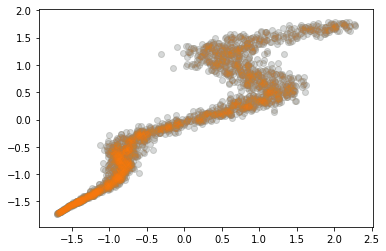

In [4]:
# replica functions for StandardScaler().fit_transform(.)
x_mu = np.mean(np.array(X_train[:,0]))
x_sd = np.std(np.array(X_train[:,0]))
y_mu = np.mean(np.array(X_train[:,1]))
y_sd = np.std(np.array(X_train[:,1]))

# test if scaling works, should produce identical plots superimposed
scale_x = (X_train[:, 0] - x_mu) / x_sd
scale_y = (X_train[:, 1] - y_mu) / y_sd
plt.scatter(scale_x, scale_y, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)

# R-NVP

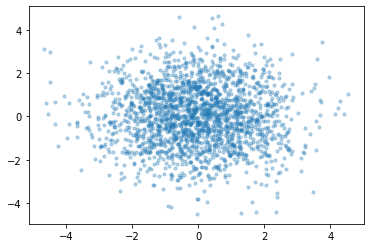

In [5]:
base_mu, base_cov = torch.zeros(2), torch.eye(2) * 2
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(2000,))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.3, s=10)
plt.show()

In [6]:
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [7]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

## Training Step Function

In [8]:
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for _ in tqdm(range(epochs)):

        # get batch 
        X= X_train
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
    return losses

In [9]:
def view(model, losses, y):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1], alpha=0.1, s=10)
    #plt.scatter(y[:, 0], y[:, 1], alpha=0.1, s=10)
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.ylim((-2.5, 2.5))
    plt.xlim((-2.5, 2.5))
    plt.show()

    n_samples = 2000
    #X = X_train
    X = X_test
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], alpha=0.2, s=20)
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()
    
    return(z, X_hat)

## Model Params

In [10]:
d = 2
k = 1

# Single Layer R_NVP

In [ ]:
model = R_NVP(d, k, hidden=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
n_samples = 512
# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

In [ ]:
z_res, x_hat_res = view(model, losses, y)

# 3 Layer R_NVP

In [ ]:
model = stacked_NVP(d, k, hidden=512, n=3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

In [ ]:
z_res, x_hat_res = view(model, losses, y)

# 5 Layer R_NVP

In [ ]:
model = stacked_NVP(d, k, hidden=512, n=5)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

In [ ]:
z_res, x_hat_res = view(model, losses, y)

# 10 Layer R_NVP

In [11]:
model = stacked_NVP(d, k, hidden=512, n=10)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 2000, n_samples, optim, scheduler)

100%|██████████| 2000/2000 [11:49<00:00,  2.82it/s]


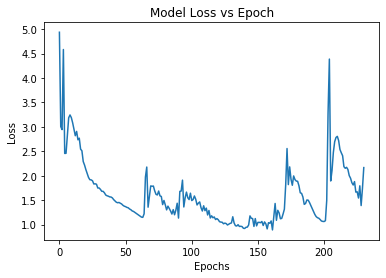

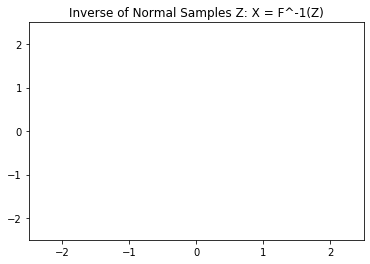

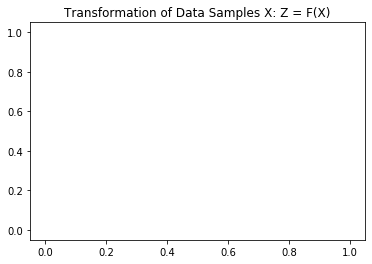

In [12]:
z_res, x_hat_res = view(model, losses, y)

# 15 Layer R_NVP

In [ ]:
model = stacked_NVP(d, k, hidden=512, n=15)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 3000, n_samples, optim, scheduler)

In [ ]:
z_res, x_hat_res = view(model, losses, y)

## 20 layer R_NVP

In [ ]:
model = stacked_NVP(d, k, hidden=512, n=20)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 2000, n_samples, optim, scheduler)

In [ ]:
z_res, x_hat_res = view(model, losses, y)

# Model Tests; generate Test Data

In [13]:
def gen_sine_wave_sample(n=2000, s=1, amp=1, wl=1,
                  ns_mean=0, ns_var=1, lim_y=True, lim_x=True, x_type='rand',
                  x_range=(0,1), y_range=(0,1), set_input=None,
                  r_rad=0, swap_axis=False, formula=2):
    # n - number of points to generate
    # s - slope gradient of wave
    # amp - amplitude of wave
    # wl - wavelength equivalent parameter
    # ns_mean, ns_var - noise mean and variance
    
    # set how the domain is generated
    if x_type == 'rand':
        x = np.random.rand(n)
    elif x_type == 'lin' :
        x = np.linspace(0, 1, n, endpoint=True)
    elif x_type == 'self' :
        x = set_input
    
    #set x limits
    if lim_x:
        x = np.interp(x, (x.min(), x.max()), x_range)
        
    epsilon = ns_mean + ns_var * np.random.randn(n)
    # apply to formula [y = s*x + mag*sin(wl*x)]
    if formula==0:
        y = s*x + amp*x*np.sin(wl*x) + epsilon
    elif formula==1:
        y = s*x + amp*x*np.sin(wl*x) + epsilon*x
    elif formula==2:
        y = s*x + amp*x*np.sin(wl*x)
    else:
        y = s*x + amp*np.sin(wl*x) + epsilon
    # create rotation matrix
    rM = np.array((np.cos(r_rad), -np.sin(r_rad), np.sin(r_rad), np.cos(r_rad))).reshape((-1, 2))
    t = np.array((x, y))
    
    # set y limits
    if lim_y:        
        t = t[:, t[1] < y_range[1]]
        t = t[:, t[1] > y_range[0]]
    
    # swap x and y axis
    if (swap_axis==True):
        t = t[[1, 0], :]
    
    # rotation matrix
    output = np.matmul(rM, t)
    
    # note that (no. of output) <= n
    return(output)
    

### ROTATION STEP

In [14]:
# scaling x_hat_res to return to original
pred_scaled_x = (x_hat_res[:, 0] * x_sd) + x_mu
pred_scaled_y = (x_hat_res[:, 1] * y_sd) + y_mu

# once scaled, we can input the data into the actual toy data generator
t = gen_sine_wave_sample(s=0.9, amp=0.25, wl=13, formula=1,
                         lim_x=False, lim_y=False, ns_var=0.09,
                         swap_axis=False,
                         x_type='self', set_input=pred_scaled_y)

# limit x
# - this may be turned off to see predictions outside of training range
results_scaled = np.array((pred_scaled_y, pred_scaled_x, t[1,:]))
results_scaled = results_scaled[:, results_scaled[0, :] <= 1]
results_scaled = results_scaled[:, results_scaled[0, :] >= 0]

C:\Users\bened\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


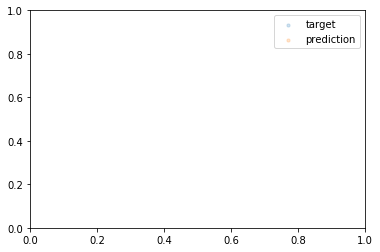

In [15]:
plt.scatter(results_scaled[2,:], results_scaled[0,:], alpha=0.2, s=10, label='target')
plt.scatter(results_scaled[1,:], results_scaled[0,:], alpha=0.2, s=10, label='prediction')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend()

# Root Mean Squared

In [16]:
t_pred = results_scaled[1,:]
t_true = results_scaled[2,:]

diff = (t_pred - t_true)
L2_diff = np.square(diff)
num_samples = len(L2_diff)

In [17]:
avg_diff = sum(np.array(L2_diff)) / num_samples
RMS = np.sqrt(avg_diff)
print("RMS: {}".format(np.around(RMS, decimals=6)))

ZeroDivisionError: division by zero

In [ ]:
plt.scatter(results_scaled[1,:], L2_diff, s=10, alpha=0.2)
plt.ylim((0,0.2))
plt.xlim((0,1))

# Log-likelihood Test

In [ ]:
# log likelihood function for toy dataset
def toy_data_log_prob_adjust_x(t, x, var=0.09):
    lp_list =[]
    for i in tqdm(range(len(t))):
        sigma_sqr = float(0.09 * (x[i] ** 2))
        f = torch.distributions.normal.Normal(0, sigma_sqr)
        lp_list.append(f.log_prob(t[i]))
    return lp_list

In [ ]:
# calculation of loglikelihood
LLp = sum(toy_data_log_prob_adjust_x(diff, pred_scaled_y))

print("Log-likelihood of predicted targets: {}".format(LLp))